In [1]:
# ! pip install scikit-learn tensorflow scikeras xgboost

# Data Cleaning

In [40]:
import os
import random
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression, RidgeCV, Ridge
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, StackingClassifier, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, 
                             classification_report, confusion_matrix, RocCurveDisplay)
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import randint
from xgboost import XGBRegressor
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier, KerasRegressor
from scikeras.wrappers import KerasRegressor
import joblib
warnings.filterwarnings('ignore')

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
print(f"Global random seed set to {SEED}")

Global random seed set to 42


In [4]:
file_path = r'Property Insurance.csv'
df = pd.read_csv(file_path)
df.head()

,Customer_ID,Age,Gender,Marital_Status,Location,Urbanization_Level,Annual_Income,Property_Value,Premium_Amount,Policy_Term,...,Building_Age,Customer_Satisfaction,Has_Security_System,Risk_Category,Expected_Claim_Cost,Construction_Type,Policy_Tenure,Payment_Method,Credit_Score,Fire_Risk_Score
0,CUST100000,59,Female,Divorced,Sabah,Rural,36070.57,100000.00,938.81,10,...,31,4.0,Yes,0,2368.13,Brick Wall,3,Online Payment,526.0,37.07
1,CUST100001,72,Male,Married,Sarawak,Urban,31683.85,105785.44,880.17,15,...,27,4.0,No,1,2133.50,Brick Wall,15,Cash,643.0,67.66
2,CUST100002,49,Male,Single,Sarawak,Rural,NaN,100000.00,885.48,15,...,26,4.0,Yes,0,7122.36,Brick Wall,1,Mortgage,715.0,51.84
3,CUST100003,35,Female,Divorced,Selangor,Rural,38979.87,171027.37,1561.45,15,...,14,3.0,Yes,1,10390.40,Lightweight Concrete,15,Financing Scheme,637.0,35.79
4,CUST100004,63,Male,Married,Sabah,Rural,NaN,100000.00,841.02,5,...,2,3.0,Yes,1,10332.28,Brick Wall,1,Cash,579.0,23.47


In [5]:

# Drop non-predictive power
df = df.drop(columns=['Customer_ID'])
df.head()

,Age,Gender,Marital_Status,Location,Urbanization_Level,Annual_Income,Property_Value,Premium_Amount,Policy_Term,Claim_Frequency,...,Building_Age,Customer_Satisfaction,Has_Security_System,Risk_Category,Expected_Claim_Cost,Construction_Type,Policy_Tenure,Payment_Method,Credit_Score,Fire_Risk_Score
0,59,Female,Divorced,Sabah,Rural,36070.57,100000.00,938.81,10,2,...,31,4.0,Yes,0,2368.13,Brick Wall,3,Online Payment,526.0,37.07
1,72,Male,Married,Sarawak,Urban,31683.85,105785.44,880.17,15,1,...,27,4.0,No,1,2133.50,Brick Wall,15,Cash,643.0,67.66
2,49,Male,Single,Sarawak,Rural,NaN,100000.00,885.48,15,2,...,26,4.0,Yes,0,7122.36,Brick Wall,1,Mortgage,715.0,51.84
3,35,Female,Divorced,Selangor,Rural,38979.87,171027.37,1561.45,15,4,...,14,3.0,Yes,1,10390.40,Lightweight Concrete,15,Financing Scheme,637.0,35.79
4,63,Male,Married,Sabah,Rural,NaN,100000.00,841.02,5,4,...,2,3.0,Yes,1,10332.28,Brick Wall,1,Cash,579.0,23.47


In [6]:
for col in df.columns:
    print(f"{col}: {df[col].isnull().sum()}")

Age: 0
Gender: 0
Marital_Status: 0
Location: 0
Urbanization_Level: 0
Annual_Income: 200
Property_Value: 150
Premium_Amount: 0
Policy_Term: 0
Claim_Frequency: 0
Claim_Amount_Last: 0
Maintenance_Level: 0
Flood_Risk_Index: 0
Crime_Rate_Index: 0
Building_Age: 0
Customer_Satisfaction: 350
Has_Security_System: 0
Risk_Category: 0
Expected_Claim_Cost: 0
Construction_Type: 250
Policy_Tenure: 0
Payment_Method: 150
Credit_Score: 200
Fire_Risk_Score: 250


In [7]:
# Categorize numerical & categorical features
categorical_features = []
numerical_features = []
for col in df.columns:
    if df[col].dtype == 'object' or df[col].nunique() <=10: # 10 states in dataset
        categorical_features.append(col)
    else:
        numerical_features.append(col)

print(f"Categorical Features:{categorical_features}")

print(f"Numerical Features:{numerical_features}")

Categorical Features:['Gender', 'Marital_Status', 'Location', 'Urbanization_Level', 'Policy_Term', 'Claim_Frequency', 'Maintenance_Level', 'Customer_Satisfaction', 'Has_Security_System', 'Risk_Category', 'Construction_Type', 'Payment_Method']
Numerical Features:['Age', 'Annual_Income', 'Property_Value', 'Premium_Amount', 'Claim_Amount_Last', 'Flood_Risk_Index', 'Crime_Rate_Index', 'Building_Age', 'Expected_Claim_Cost', 'Policy_Tenure', 'Credit_Score', 'Fire_Risk_Score']


In [8]:
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

df[categorical_features + numerical_features] = (
    df[categorical_features + numerical_features]
    .apply(pd.to_numeric, errors='coerce')
)

df.head()

,Age,Gender,Marital_Status,Location,Urbanization_Level,Annual_Income,Property_Value,Premium_Amount,Policy_Term,Claim_Frequency,...,Building_Age,Customer_Satisfaction,Has_Security_System,Risk_Category,Expected_Claim_Cost,Construction_Type,Policy_Tenure,Payment_Method,Credit_Score,Fire_Risk_Score
0,59,0,0,7,0,36070.57,100000.00,938.81,0,2,...,31,3,1,0,2368.13,0,3,4,526.0,37.07
1,72,1,1,8,2,31683.85,105785.44,880.17,1,1,...,27,3,0,1,2133.50,0,15,1,643.0,67.66
2,49,1,2,8,0,NaN,100000.00,885.48,1,2,...,26,3,1,0,7122.36,0,1,3,715.0,51.84
3,35,0,0,9,0,38979.87,171027.37,1561.45,1,4,...,14,2,1,1,10390.40,1,15,2,637.0,35.79
4,63,1,1,7,0,NaN,100000.00,841.02,3,4,...,2,2,1,1,10332.28,0,1,1,579.0,23.47


In [9]:
# Impute missing cell using random forest model 
def impute_with_rf(df):
    for col in df.columns[df.isnull().any()]:
        is_numerical = col in numerical_features
        predictor_cols = df.columns.drop(col)
        train, test = df[df[col].notnull()], df[df[col].isnull()]

        x_train, x_test = train[predictor_cols].copy(), test[predictor_cols].copy()

        for feat in predictor_cols:
            fill_val = df[feat].median() if feat in numerical_features else df[feat].mode()[0]
            x_train[feat], x_test[feat] = x_train[feat].fillna(fill_val), x_test[feat].fillna(fill_val)

        model = (RandomForestRegressor(n_estimators=100, random_state=SEED) if is_numerical
                 else RandomForestClassifier(n_estimators=100, random_state=SEED))
        model.fit(x_train, train[col])

        preds = model.predict(x_test)
        df.loc[df[col].isnull(), col] = preds if is_numerical else np.round(preds).astype(int)

    return df

df = impute_with_rf(df)

for col in df.columns:
    print(f"{col}: {df[col].isnull().sum()}")

Age: 0
Gender: 0
Marital_Status: 0
Location: 0
Urbanization_Level: 0
Annual_Income: 0
Property_Value: 0
Premium_Amount: 0
Policy_Term: 0
Claim_Frequency: 0
Claim_Amount_Last: 0
Maintenance_Level: 0
Flood_Risk_Index: 0
Crime_Rate_Index: 0
Building_Age: 0
Customer_Satisfaction: 0
Has_Security_System: 0
Risk_Category: 0
Expected_Claim_Cost: 0
Construction_Type: 0
Policy_Tenure: 0
Payment_Method: 0
Credit_Score: 0
Fire_Risk_Score: 0


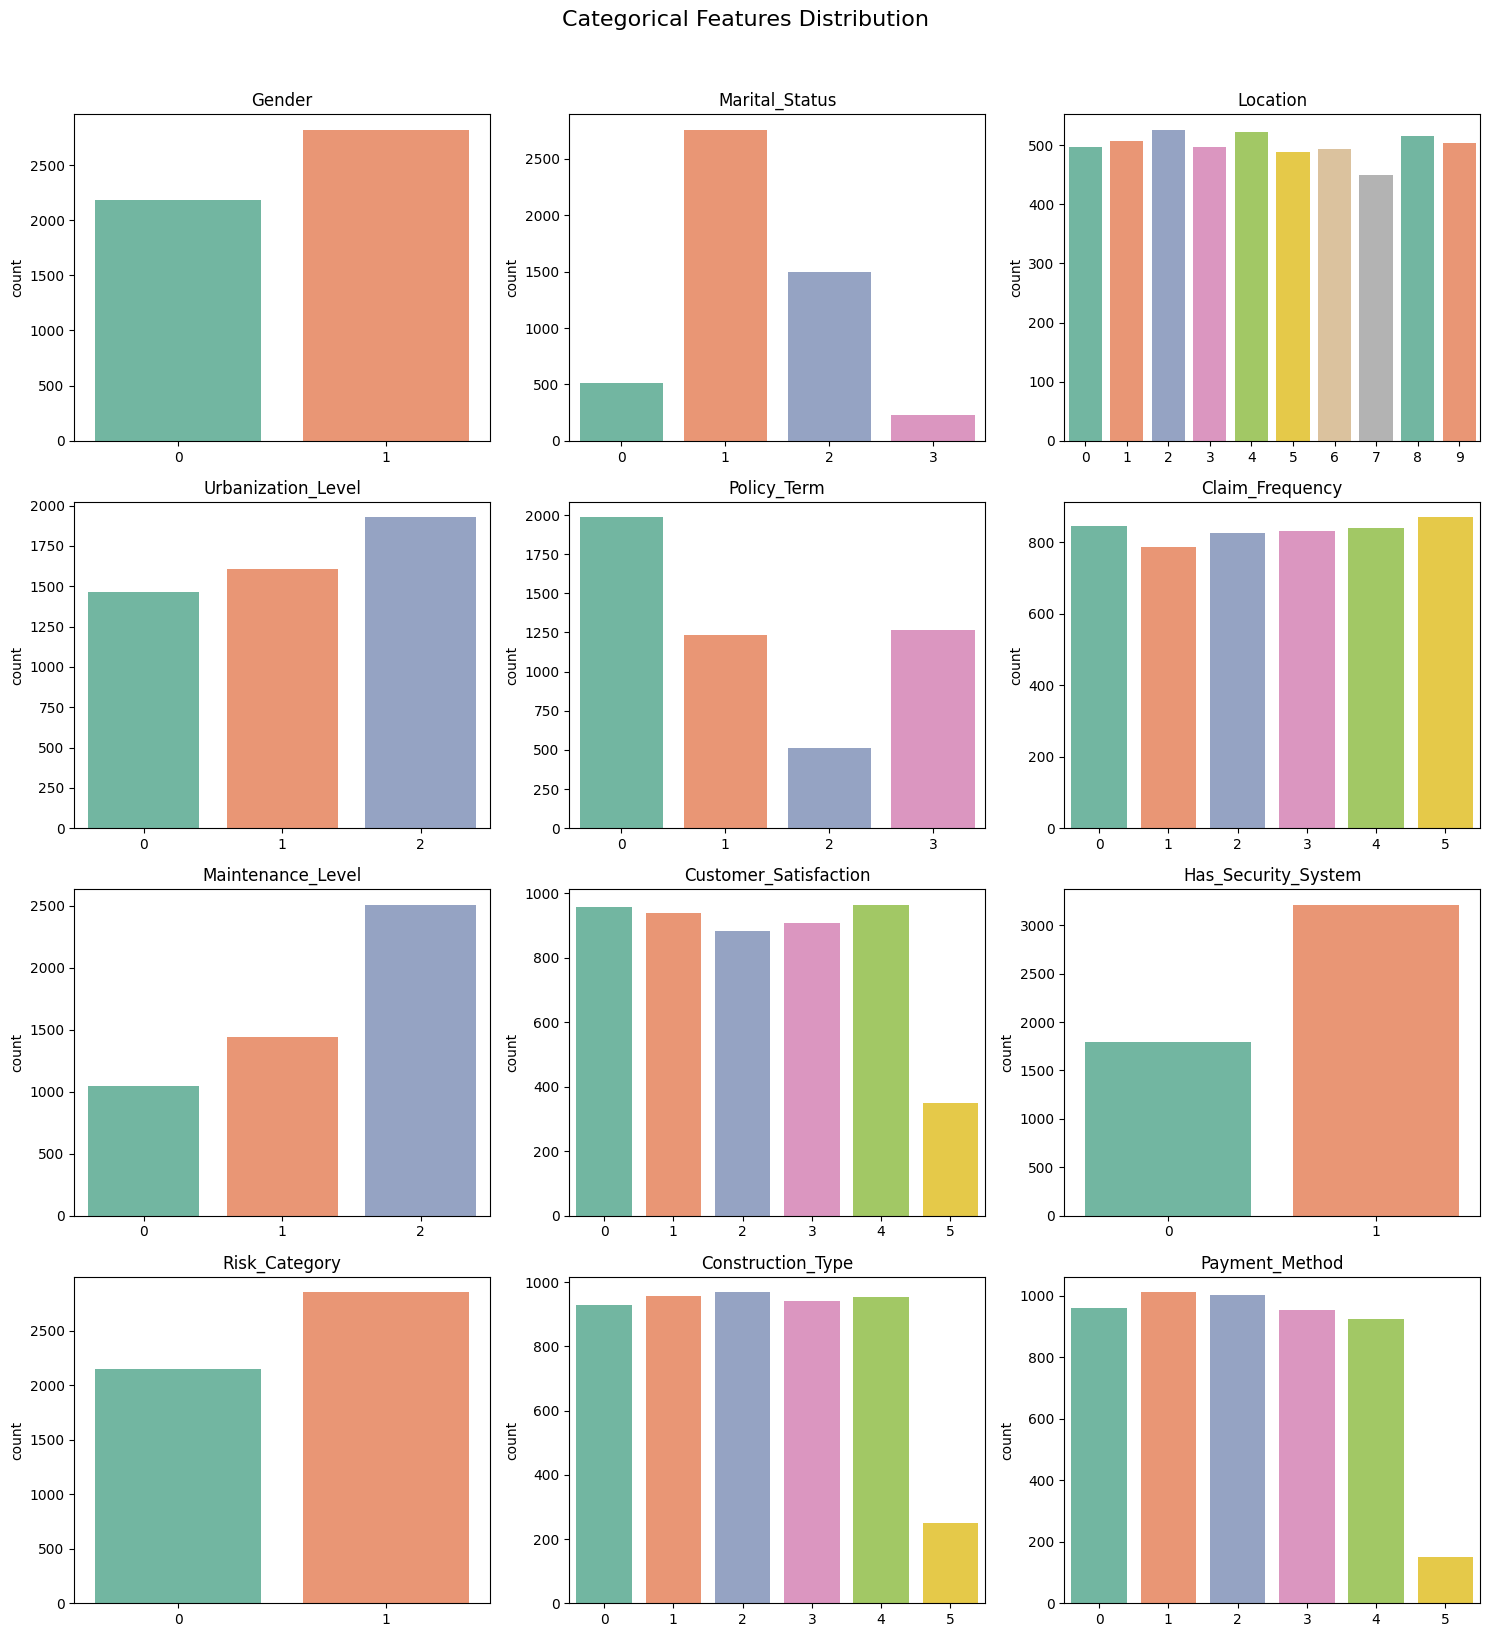

In [10]:

# Univariate for categorical features
n_cols = 3
n_rows = -(-len(categorical_features) // n_cols)  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    sns.countplot(x=df[col], hue=df[col], legend=False, ax=axes[i], palette='Set2')
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Categorical Features Distribution', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

The categorical features distribution reveals several notable patterns. Gender shows a noticeable imbalance with class 1 (male) having more counts than class 0, while Marital_Status is heavily dominated by class 1 (married) followed by class 2 (single), with divorced and widowed being minority classes. Location shows a fairly uniform distribution across all 10 locations, suggesting good geographical representation. Claim_Frequency is evenly distributed across all frequency levels, indicating a well-balanced sampling. Customer_Satisfaction is relatively uniform except for level 5 which drops significantly, suggesting fewer highly satisfied customers. Has_Security_System shows a clear imbalance where properties with security systems (1) are nearly double those without. Construction_Type and Payment_Method are mostly uniform except for the last category which drops sharply, indicating rare construction types and payment methods. Most importantly, Risk_Category confirms a class imbalance with class 1 outnumbering class 0, reinforcing the need for class weighting before model training.

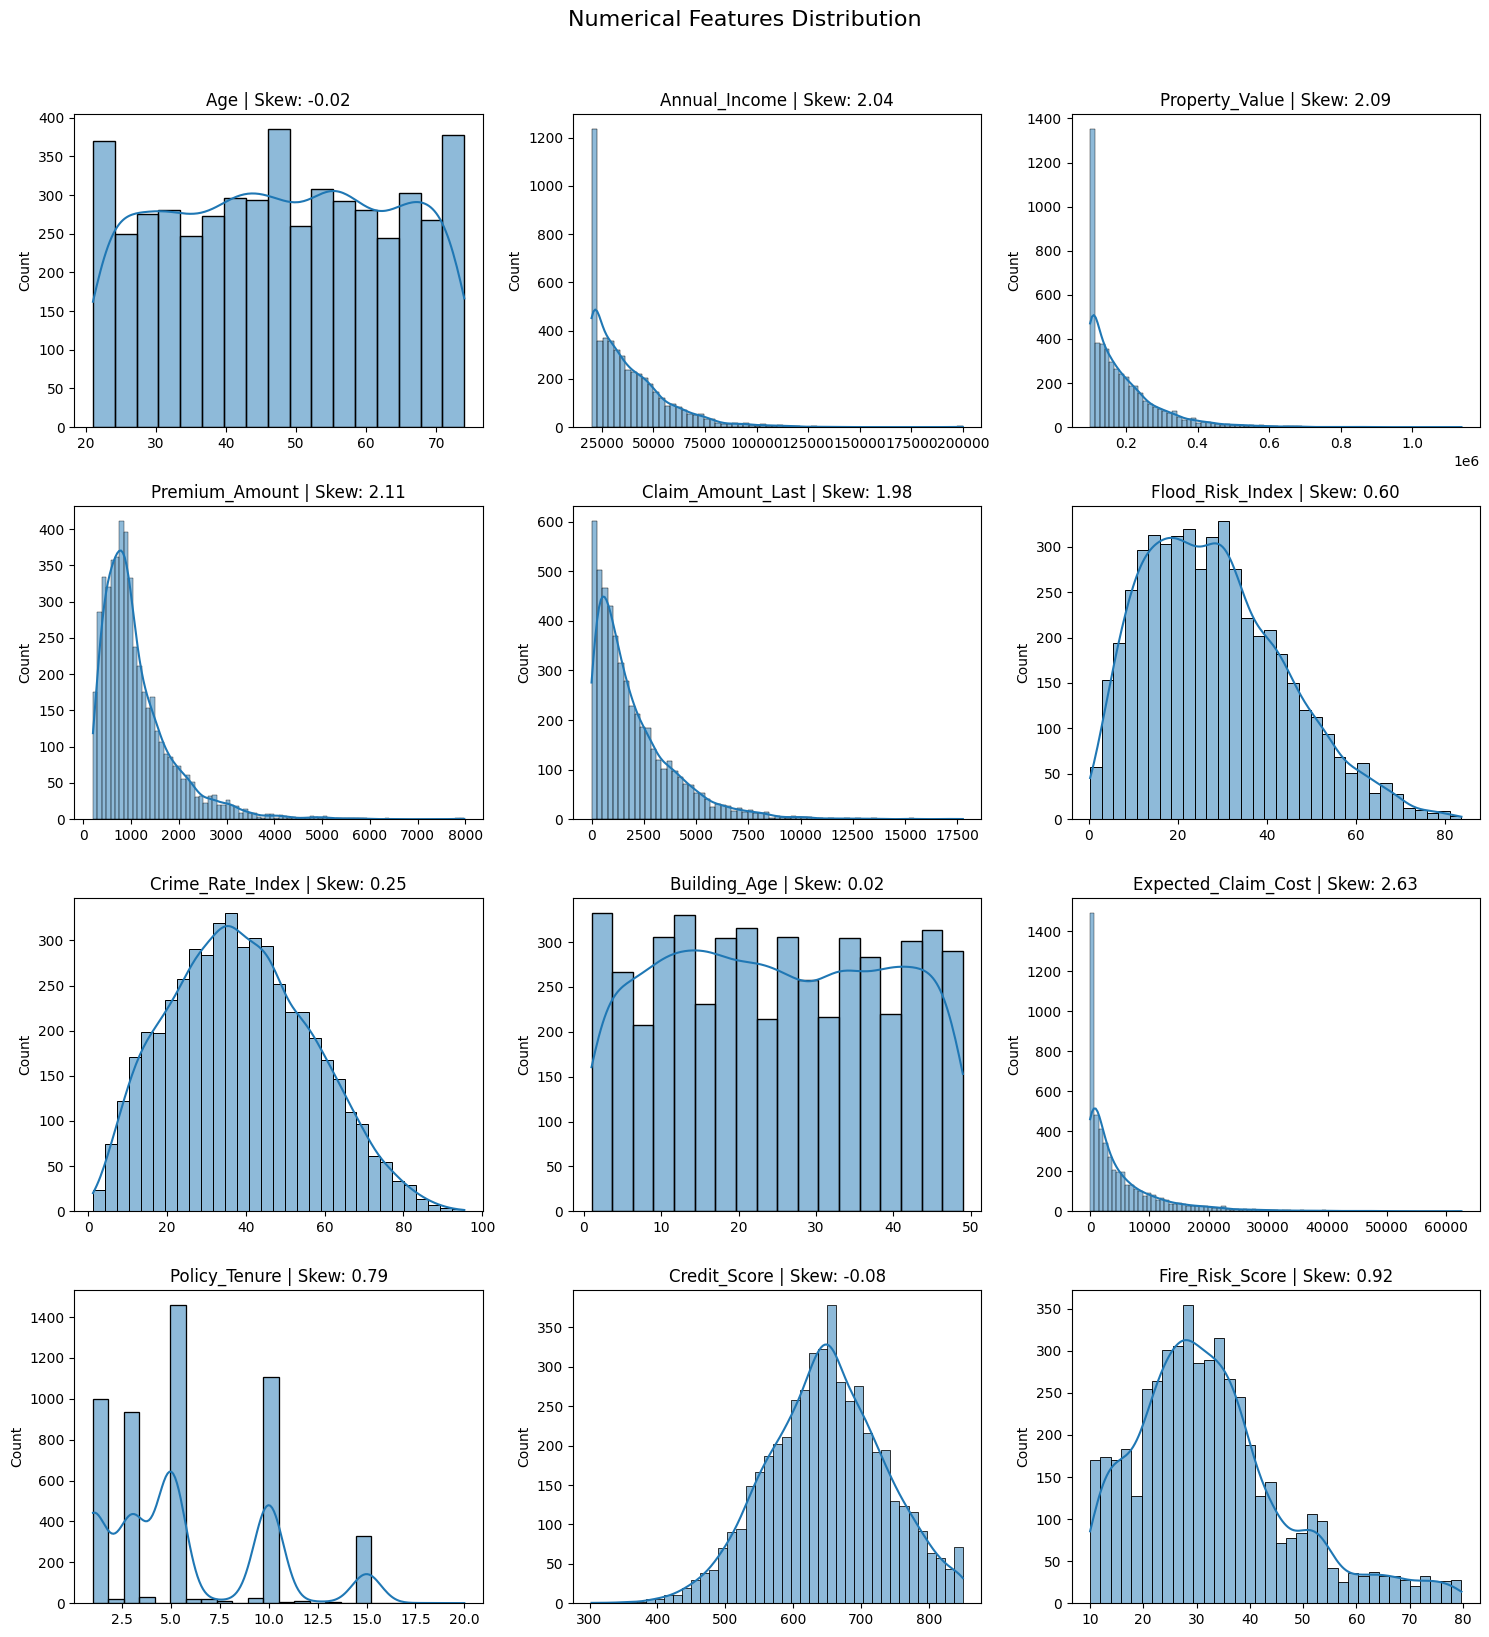

In [11]:
# Univariate for numerical features
num_cols = numerical_features
n_rows = -(-len(num_cols) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], ax=axes[i], kde=True)
    axes[i].set_title(f'{col} | Skew: {df[col].skew():.2f}')
    axes[i].set_xlabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Numerical Features Distribution', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

The numerical features distribution reveals clear patterns across different feature types. Annual_Income, Property_Value, Premium_Amount, Claim_Amount_Last and Expected_Claim_Cost all show strong right skewness (skew > 1.5), indicating heavy concentration of low values with long tails toward higher values, requiring log transformation before model training. Age and Building_Age show near-uniform distributions (skew close to 0), suggesting these features are well-balanced across the dataset. Credit_Score follows a near-normal distribution centered around 600-700, which is ideal and requires no transformation. Policy_Tenure shows a multimodal distribution with distinct peaks at 2.5, 5, 10 and 15, confirming it should be treated as a categorical feature rather than numerical. Fire_Risk_Score and Flood_Risk_Index show moderate right skew (0.60-0.92), borderline for transformation. Overall, log transformation should be applied to features with skewness above 1 before proceeding to model training.

In [12]:
# Combine risk indices into a single area risk feature to prevent data leakage
risk_cols = [col for col in ['Flood_Risk_Index', 'Crime_Rate_Index'] if col in df.columns]
if risk_cols:
    df['Area_Risk_Index'] = df[risk_cols].mean(axis=1)
    df = df.drop(columns=risk_cols)
    numerical_features = [col for col in numerical_features if col not in risk_cols]
    numerical_features.append('Area_Risk_Index')

# Drop low-value location columns dynamically
drop_cols = [col for col in ['Location'] if col in df.columns]
if drop_cols:
    df = df.drop(columns=drop_cols)
    categorical_features = [col for col in categorical_features if col not in drop_cols]

df.head()

,Age,Gender,Marital_Status,Urbanization_Level,Annual_Income,Property_Value,Premium_Amount,Policy_Term,Claim_Frequency,Claim_Amount_Last,...,Customer_Satisfaction,Has_Security_System,Risk_Category,Expected_Claim_Cost,Construction_Type,Policy_Tenure,Payment_Method,Credit_Score,Fire_Risk_Score,Area_Risk_Index
0,59,0,0,0,36070.5700,100000.00,938.81,0,2,1731.54,...,3,1,0,2368.13,0,3,4,526.0,37.07,47.955
1,72,1,1,2,31683.8500,105785.44,880.17,1,1,1739.83,...,3,0,1,2133.50,0,15,1,643.0,67.66,47.265
2,49,1,2,0,24442.1606,100000.00,885.48,1,2,3884.38,...,3,1,0,7122.36,0,1,3,715.0,51.84,29.635
3,35,0,0,0,38979.8700,171027.37,1561.45,1,4,2113.10,...,2,1,1,10390.40,1,15,2,637.0,35.79,25.255
4,63,1,1,0,29946.9088,100000.00,841.02,3,4,2695.98,...,2,1,1,10332.28,0,1,1,579.0,23.47,34.035


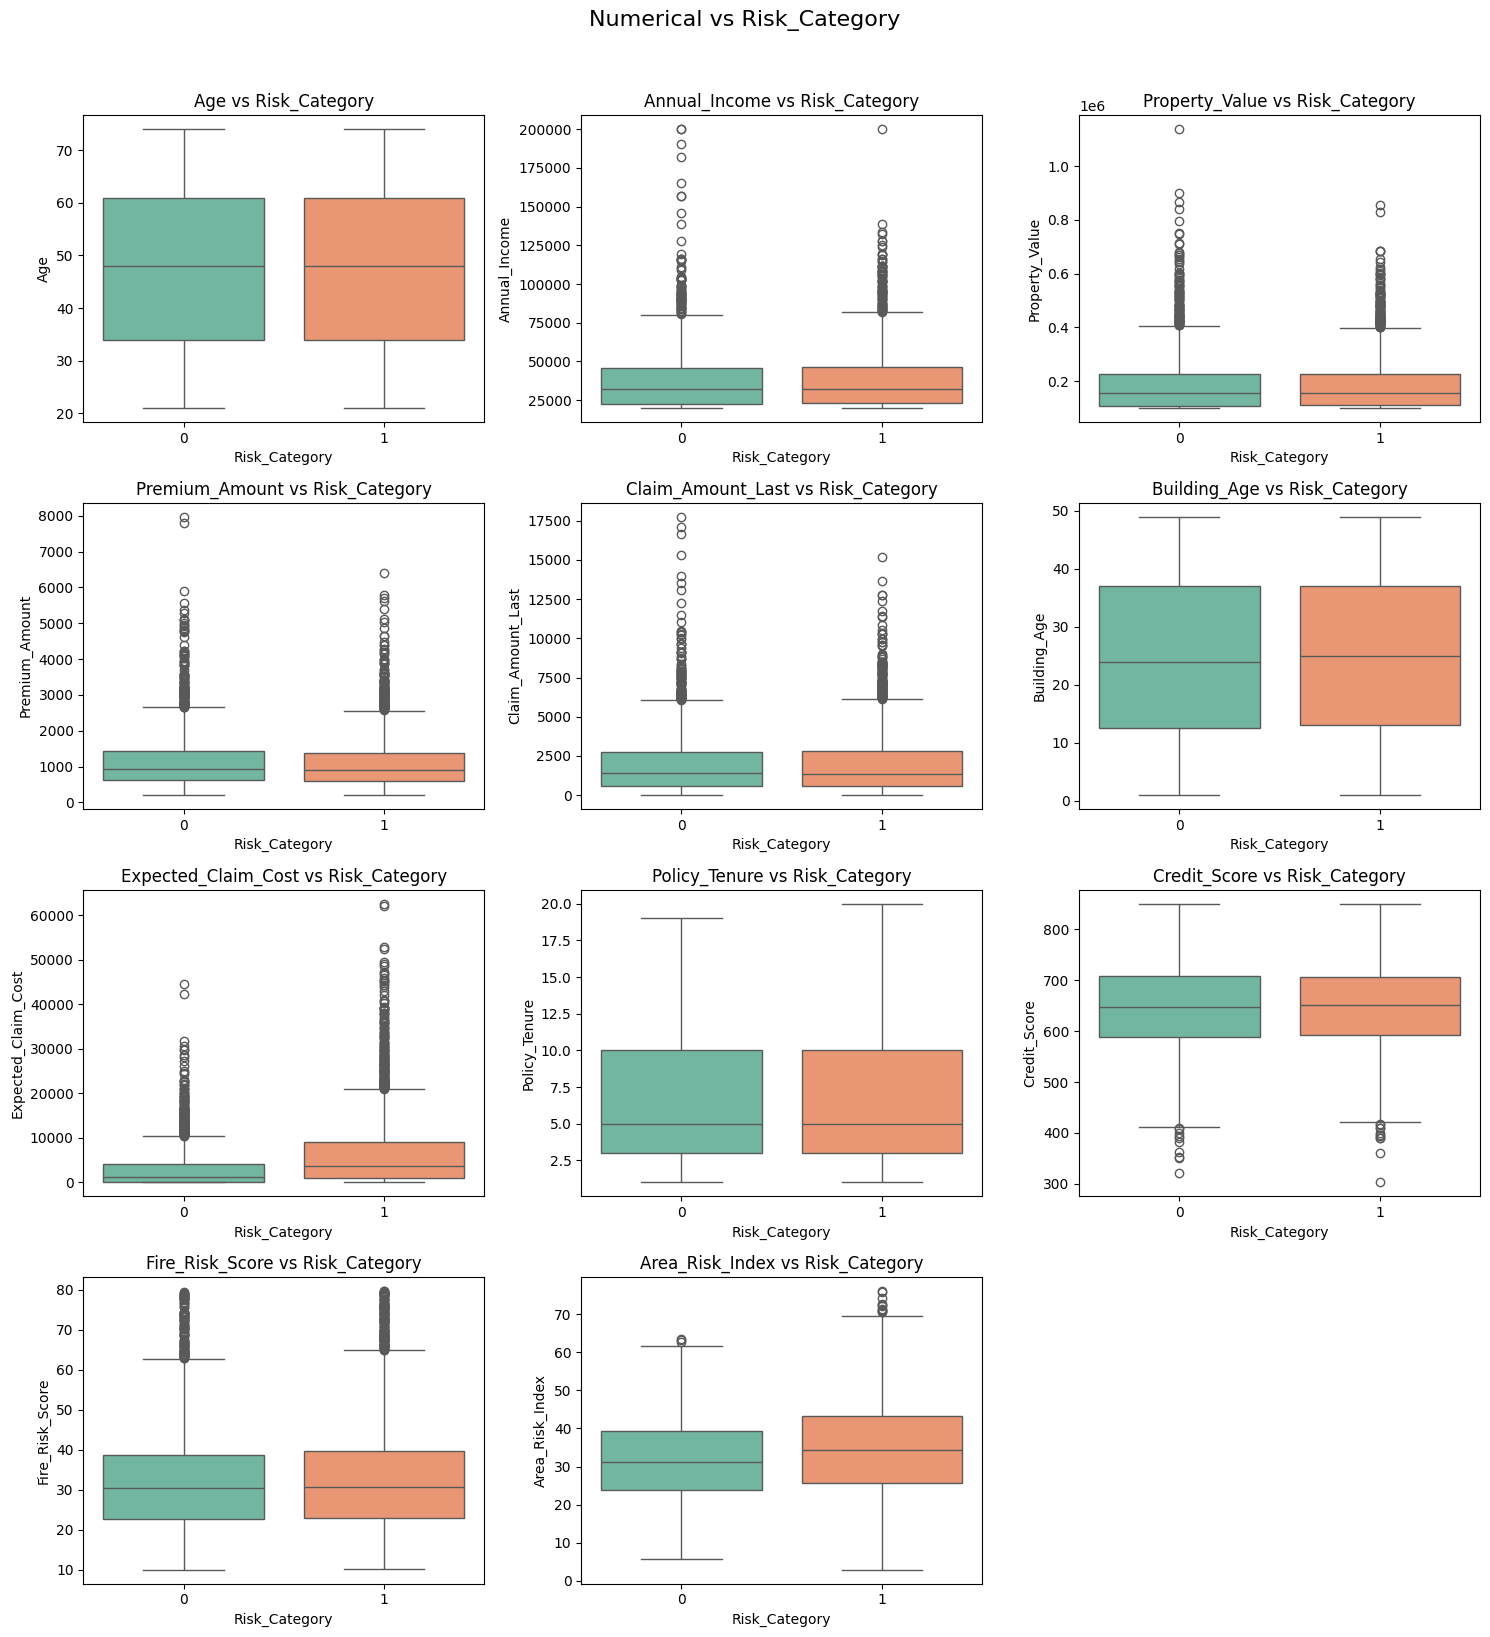

In [13]:
# 1. Numerical vs Risk_Category (Boxplot)
n_cols = 3
n_rows = -(-len(numerical_features) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    sns.boxplot(x=df['Risk_Category'], y=df[col], hue=df['Risk_Category'], legend=False, ax=axes[i], palette='Set2')
    axes[i].set_title(f'{col} vs Risk_Category')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Numerical vs Risk_Category', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

The most striking observation is the heavy presence of outliers across almost all numerical features, particularly in Annual_Income, Property_Value, Premium_Amount, Claim_Amount_Last and Expected_Claim_Cost. These extreme outliers suggest the data is heavily right-skewed and log transformation should be applied before model training. The median distributions between class 0 and class 1 remain very similar for most features, confirming weak linear separability. Expected_Claim_Cost is the exception, showing both higher median and more extreme outliers for class 1, making it the strongest predictor.

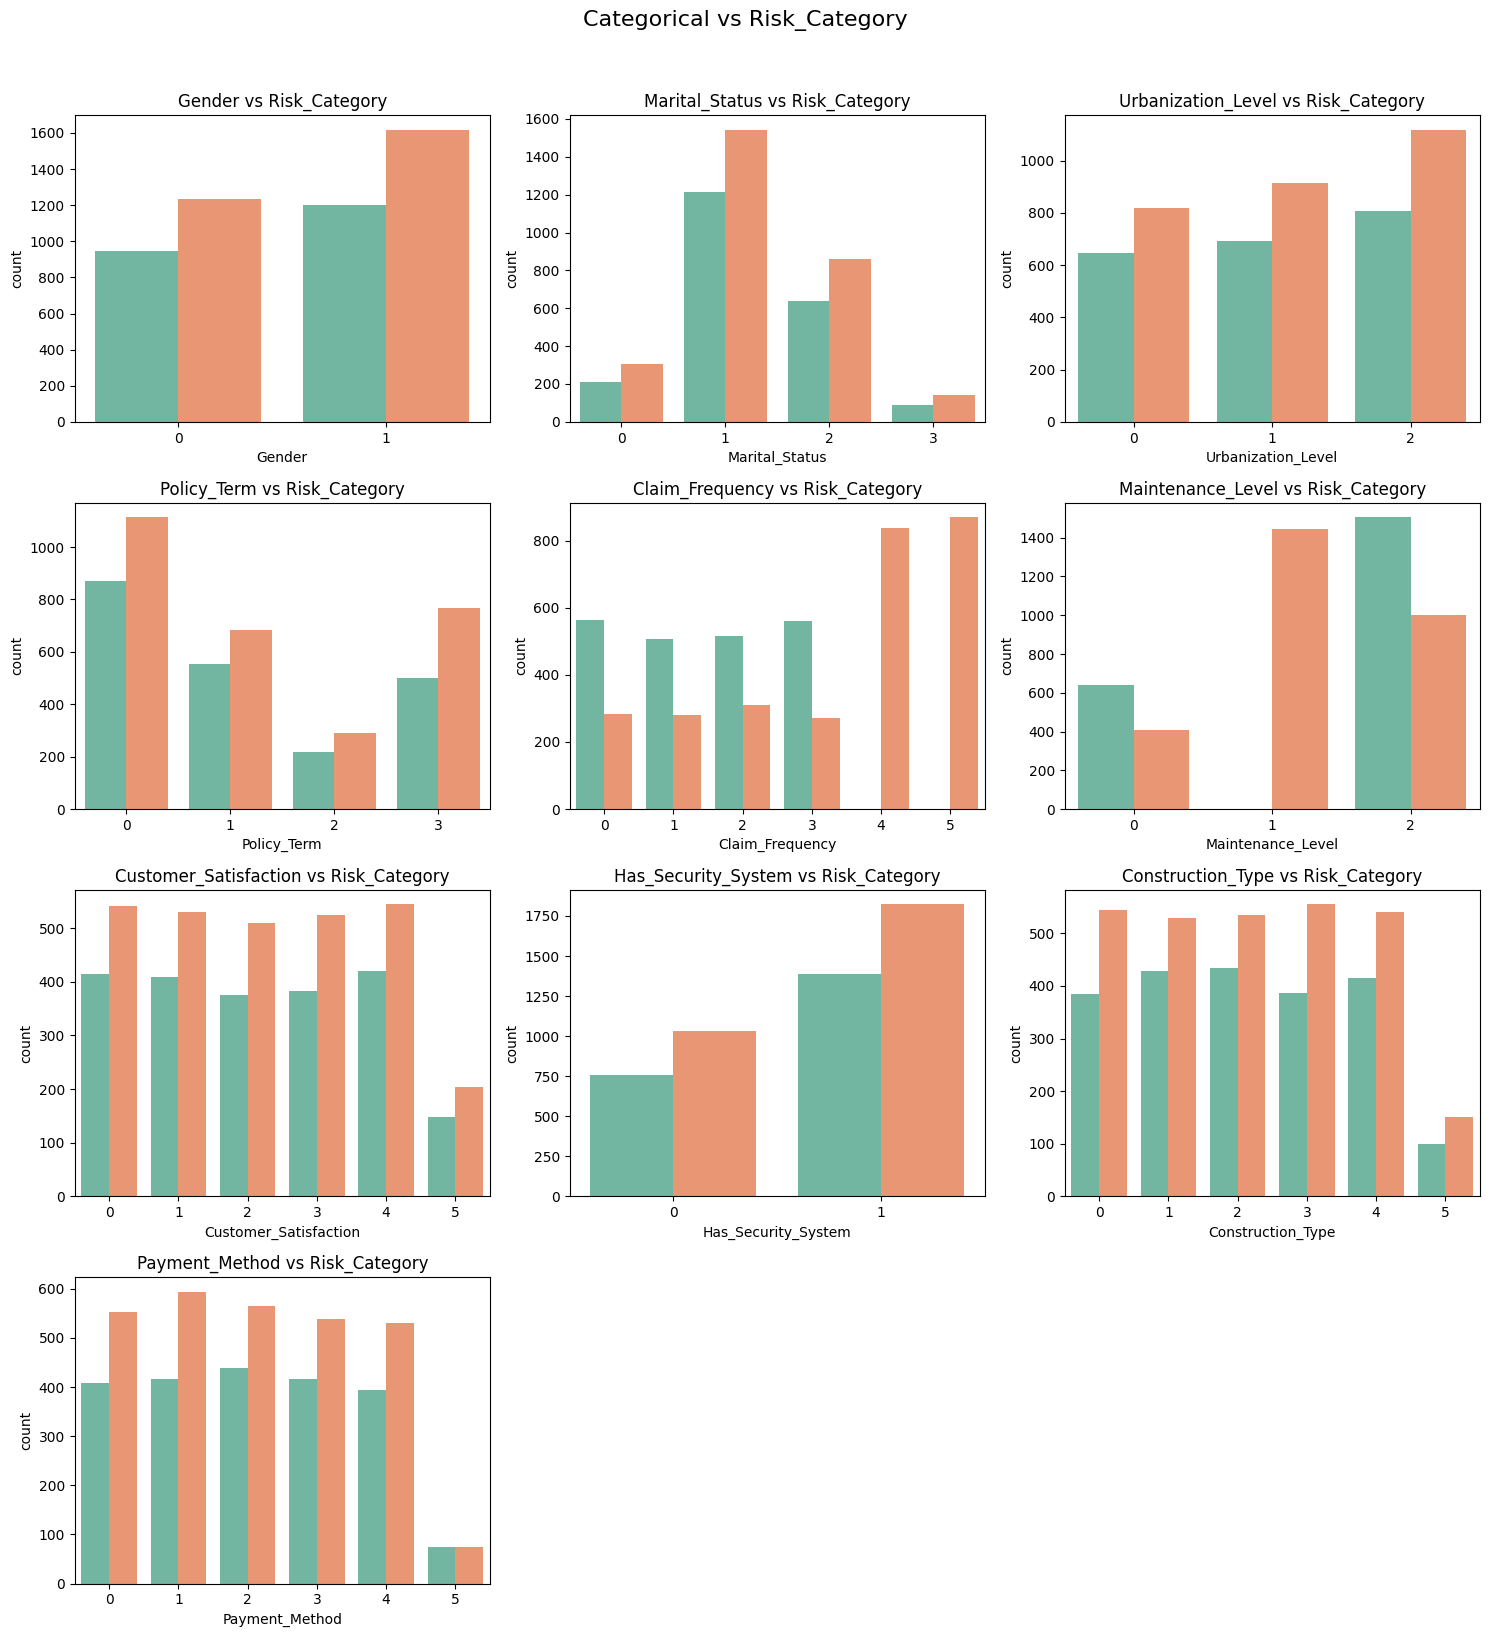

In [14]:
# 2. Categorical vs Risk_Category (Countplot)
cat_plot = [col for col in categorical_features if col != 'Risk_Category']
n_rows = -(-len(cat_plot) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(cat_plot):
    sns.countplot(x=df[col], hue=df['Risk_Category'], legend=False, ax=axes[i], palette='Set2')
    axes[i].set_title(f'{col} vs Risk_Category')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Categorical vs Risk_Category', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

The categorical bivariate analysis indicates that Claim_Frequency and Maintenance_Level are the most potent predictors, with higher values in these categories strongly associated with the majority Risk_Category 1. A counterintuitive trend is observed in Has_Security_System, where the presence of a system correlates with higher risk, potentially acting as a proxy for high-value or high-exposure locations. Conversely, Gender, Construction_Type, and Payment_Method display near-uniform distributions, suggesting minimal predictive power. To address the observed class imbalance where Class 1 significantly outnumbers Class 0, Class Weighting will be prioritized over SMOTE to preserve the statistical integrity of the 5,000-row sample and avoid overfitting to synthetic minority instances.

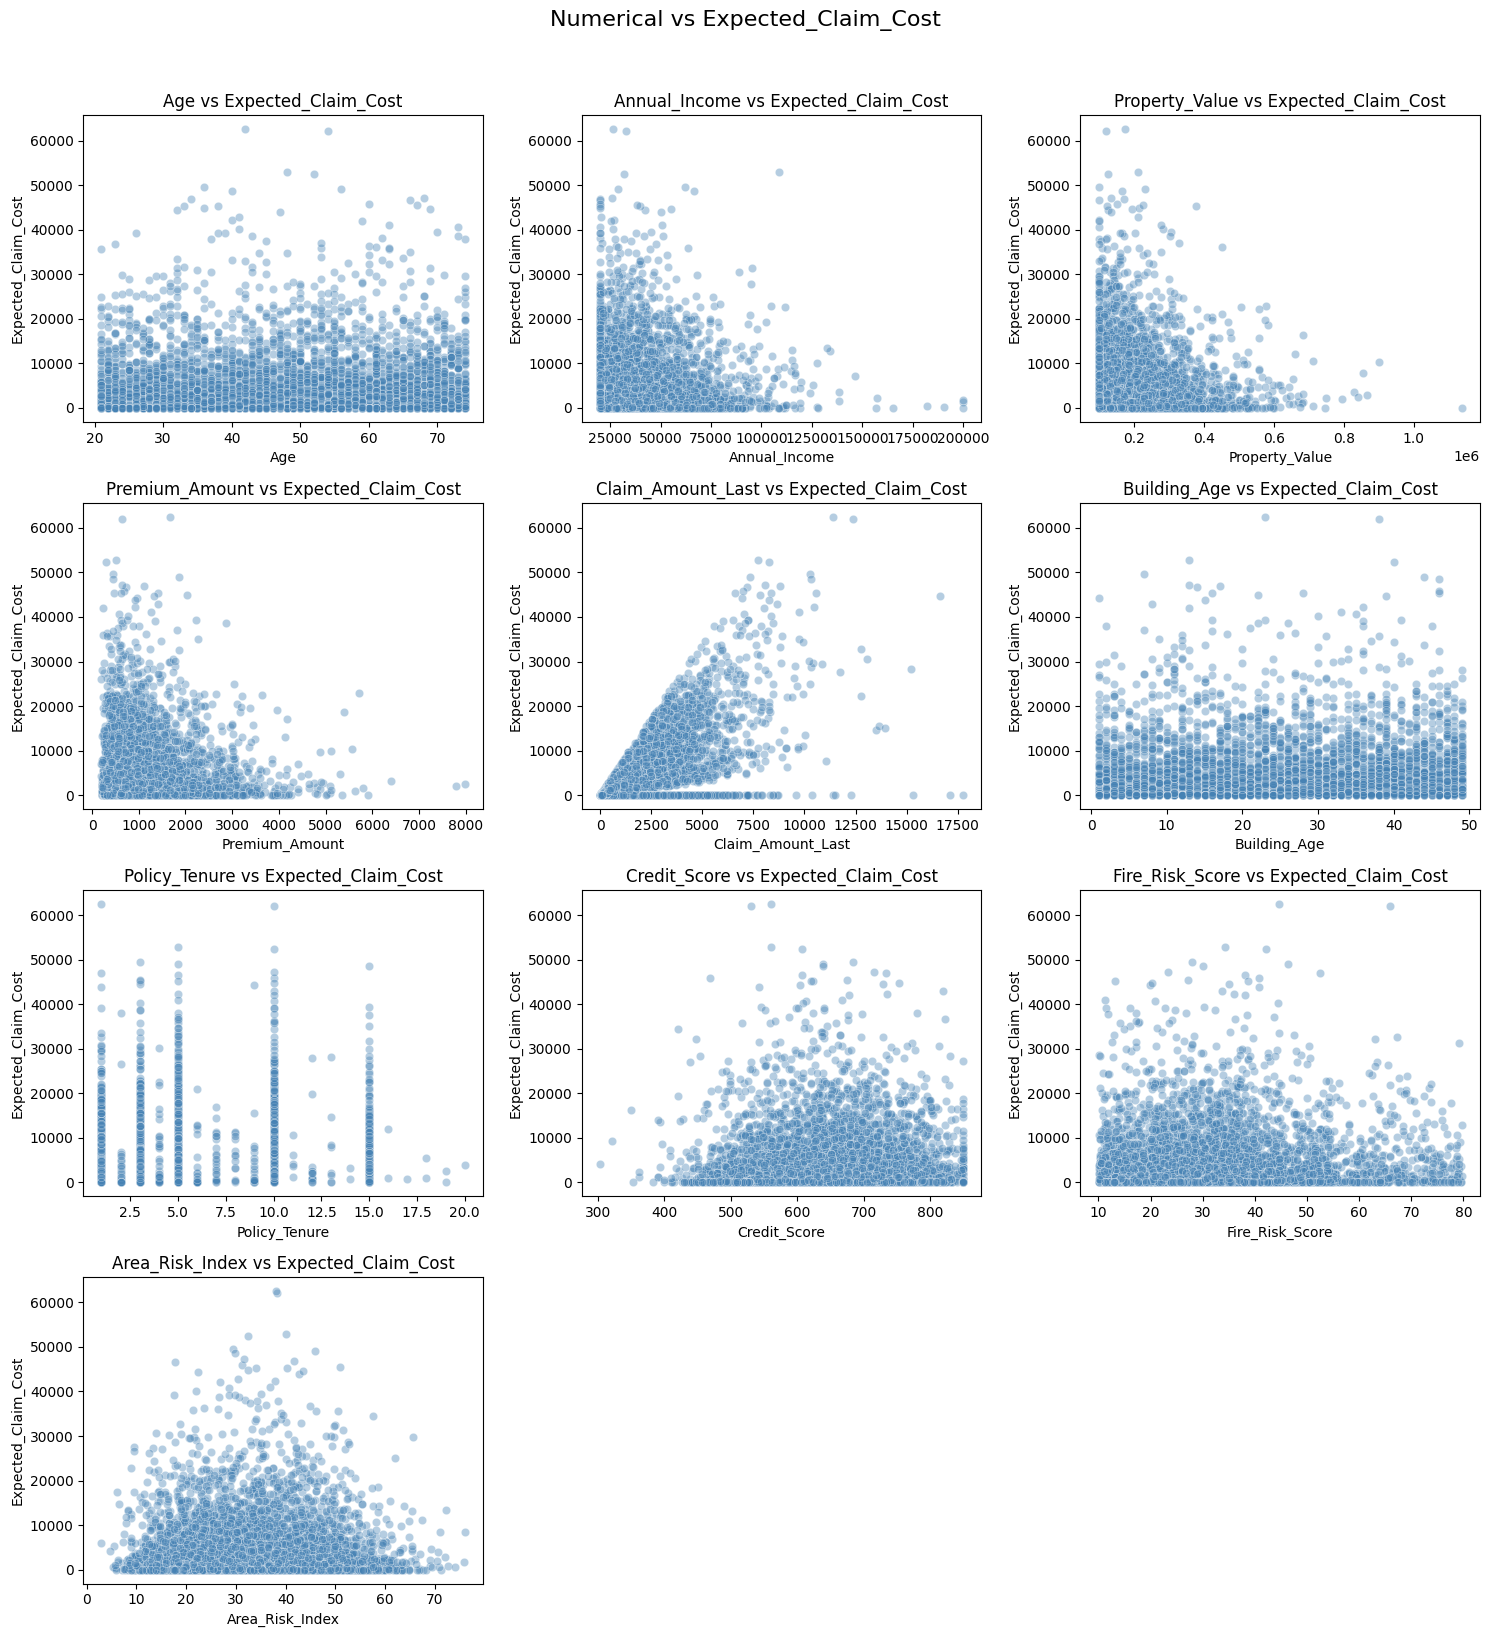

In [15]:
# 3. Numerical vs Expected_Claim_Cost (Scatterplot)
num_plot = [col for col in numerical_features if col != 'Expected_Claim_Cost']
n_rows = -(-len(num_plot) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(num_plot):
    sns.scatterplot(x=df[col], y=df['Expected_Claim_Cost'], ax=axes[i], alpha=0.4, color='steelblue')
    axes[i].set_title(f'{col} vs Expected_Claim_Cost')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Numerical vs Expected_Claim_Cost', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Almost all numerical features show no clear linear relationship with Expected_Claim_Cost, with points scattered randomly across the entire range. The exception is Claim_Amount_Last, which displays a strong positive linear relationship, making it the most dominant predictor for regression. Policy_Tenure again shows distinct vertical columns confirming it should be treated as categorical. The weak relationships observed across most features suggest the regression task will be challenging, requiring non-linear models like Gradient Boosting and ANN to extract hidden patterns beyond what Claim_Amount_Last alone provides.

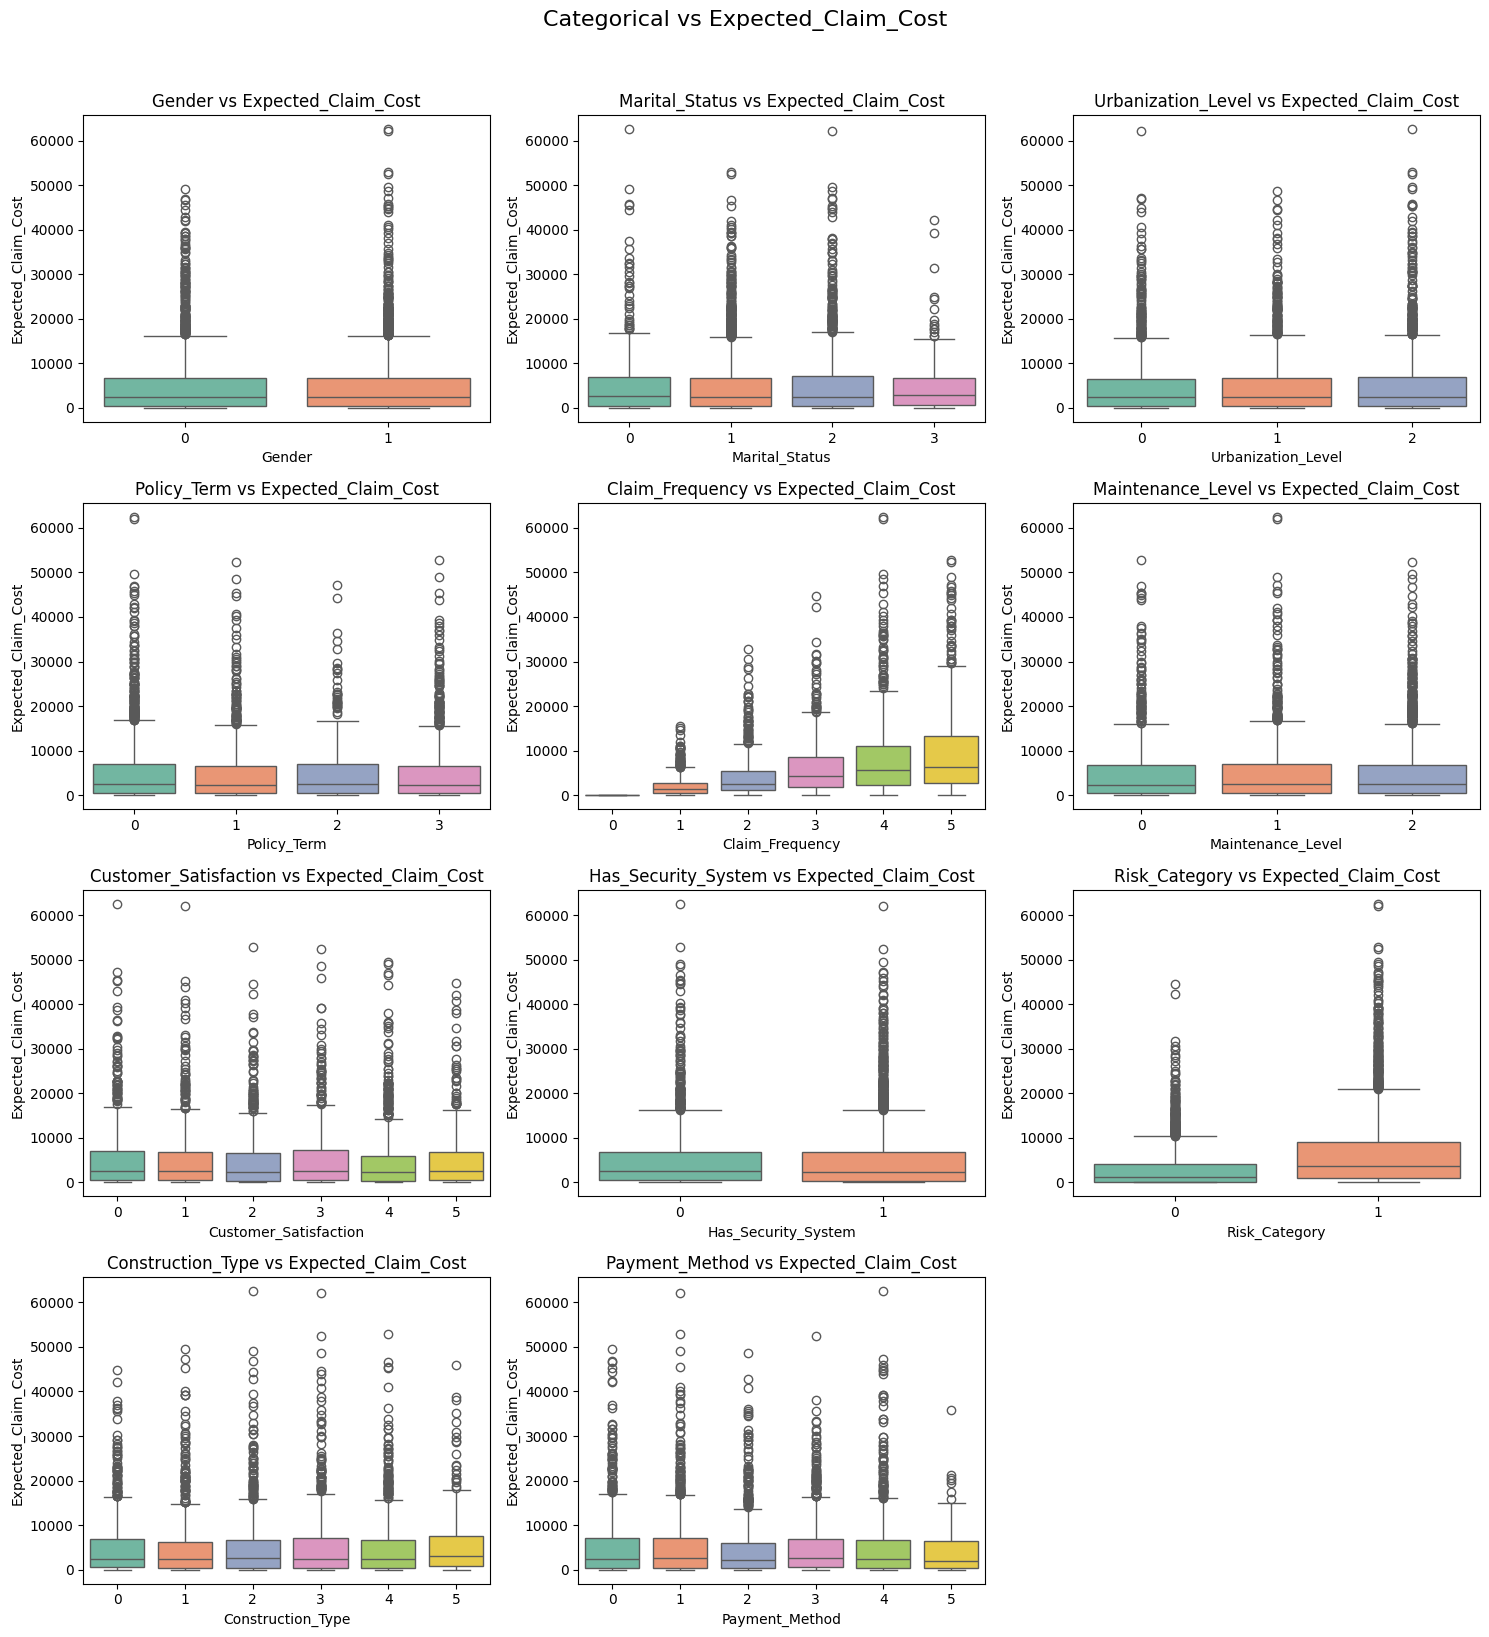

In [16]:
# 4. Categorical vs Expected_Claim_Cost (Boxplot)
n_rows = -(-len(categorical_features) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    sns.boxplot(x=df[col], y=df['Expected_Claim_Cost'], hue=df[col], legend=False, ax=axes[i], palette='Set2')
    axes[i].set_title(f'{col} vs Expected_Claim_Cost')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Categorical vs Expected_Claim_Cost', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

 Outliers are visible across all categorical groups, with extreme high values scattered consistently above the whiskers. Despite the outliers, the IQR boxes remain almost identical across all categories, confirming that no single categorical feature meaningfully separates Expected_Claim_Cost values.

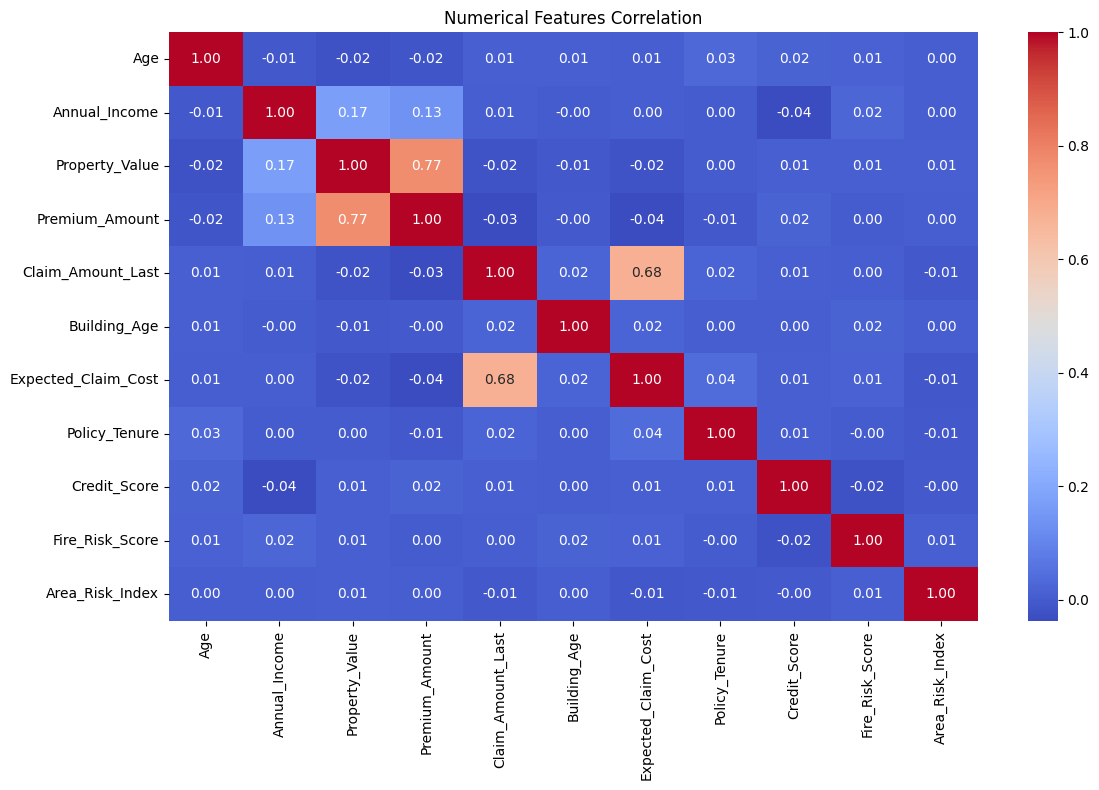

In [17]:
# 5. Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Numerical Features Correlation')
plt.tight_layout()
plt.show()

In general, the numerical variables exhibit very weak correlations, which implies low multicollinearity and highly independent characteristics. The highest positive correlation is between Property_Value and Premium_Amount (r = 0.77), indicating that higher property value is linked with more premiums. There is another moderate positive relation between Claim_Amount_Last and Expected_Claim_Cost (r = 0.68), which implies that the previous amount of claims has some effect on the future costs. The rest of the variables including Age, Building_Age, and Area_Risk_Index have insignificant correlation with each other, whereas Annual_Income has weak positive relations with Property_Value and Premium_Amount.


In [18]:
# Apply log transformation to heavily skewed columns
skewed_cols = ['Annual_Income', 'Property_Value', 'Premium_Amount', 
               'Claim_Amount_Last', 'Expected_Claim_Cost']

for col in skewed_cols:
    new_col = f'log_{col}'
    df[new_col] = np.log1p(df[col])
    df = df.drop(columns=[col])

# Update numerical features list
numerical_features = [f'log_{col}' if col in skewed_cols else col for col in numerical_features]

print(df[[f'log_{col}' for col in skewed_cols]].skew())


log_Annual_Income          0.588576
log_Property_Value         0.723423
log_Premium_Amount         0.082617
log_Claim_Amount_Last     -1.055414
log_Expected_Claim_Cost   -1.236975
dtype: float64


log_Claim_Amount_Last and log_Expected_Claim_Cost went negative skew after log transform, meaning slightly over-transformed. But they're still within acceptable range for ANN since ANN doesn't assume normality unlike linear models.

In [19]:
# Define features and both targets
X = df.drop(columns=['Risk_Category', 'log_Expected_Claim_Cost'])
y_class = df['Risk_Category']
y_reg = df['log_Expected_Claim_Cost']

# Single split for both targets
X_train, X_test, y_train_class, y_test_class, y_train_reg, y_test_reg = train_test_split(
    X, y_class, y_reg, test_size=0.2, random_state=SEED, stratify=y_class
)

# Scale numerical features
scale_features = [col for col in numerical_features if col in X_train.columns]
scaler_X = StandardScaler()
X_train[scale_features] = scaler_X.fit_transform(X_train[scale_features])
X_test[scale_features] = scaler_X.transform(X_test[scale_features])

scaler_y = StandardScaler()
y_train_reg = scaler_y.fit_transform(y_train_reg.values.reshape(-1, 1)).flatten()
y_test_reg = scaler_y.transform(y_test_reg.values.reshape(-1, 1)).flatten()

print(f"Train size: {X_train.shape}")
print(f"Test size: {X_test.shape}")

Train size: (4000, 20)
Test size: (1000, 20)


# Classification - Risk_Category

In [20]:
def evaluate_classification(model_name, y_test, y_pred, y_prob):
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc = roc_auc_score(y_test, y_prob)
    print(f"Model: {model_name}")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"ROC-AUC  : {roc:.4f}")
    return {'model': model_name, 'accuracy': acc, 'f1': f1, 'roc_auc': roc}

In [21]:
# Logistic regression
lr = LogisticRegression(class_weight='balanced', random_state=SEED, max_iter=100)
lr.fit(X_train, y_train_class)
lr_pred = lr.predict(X_test)
lr_prob = lr.predict_proba(X_test)[:, 1]
lr_results = evaluate_classification('Logistic Regression', y_test_class, lr_pred, lr_prob)

# Check overfitting
print(f"Logistic Regression Train: {accuracy_score(y_train_class, lr.predict(X_train)):.4f}")
print(f"Logistic Regression Test:  {accuracy_score(y_test_class, lr_pred):.4f}")

Model: Logistic Regression
Accuracy : 0.7430
F1 Score : 0.7441
ROC-AUC  : 0.8235
Logistic Regression Train: 0.7440
Logistic Regression Test:  0.7430


Logistic Regression was selected as the baseline classification model despite the data showing non-linear relationships. As a linear model, it is expected to underperform compared to non-linear models like Random Forest and ANN, however this is intentional — its purpose is to establish a minimum performance benchmark. With an accuracy of 0.7430, F1 score of 0.7441, and ROC-AUC of 0.8235, it serves as the lower bound. The negligible gap between train and test accuracy (0.744 vs 0.743) confirms no overfitting. If non-linear models cannot outperform Logistic Regression, it would indicate a problem in the modelling pipeline. The performance gap between Logistic Regression and the non-linear models serves as quantitative justification for the added complexity of Random Forest and ANN.

In [22]:
# Random forest
rf = RandomForestClassifier(n_estimators=100, 
                            max_depth=10,
                            min_samples_leaf=5,
                            class_weight='balanced', 
                            random_state=SEED, 
                            n_jobs=-1
                            )
rf.fit(X_train, y_train_class)
rf_pred = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)[:, 1]
rf_results = evaluate_classification('Random Forest', y_test_class, rf_pred, rf_prob)

# Check overfitting
print(f"Random Forest Train: {accuracy_score(y_train_class, rf.predict(X_train)):.4f}")
print(f"Random Forest Test:  {accuracy_score(y_test_class, rf_pred):.4f}")

Model: Random Forest
Accuracy : 0.9730
F1 Score : 0.9731
ROC-AUC  : 0.9907
Random Forest Train: 0.9792
Random Forest Test:  0.9730


Random Forest was selected as the tree-based model for several reasons. Unlike a single Decision Tree which is prone to overfitting, Random Forest builds multiple trees and averages their predictions, resulting in more stable and generalisable performance. Compared to other tree-based models like Gradient Boosting and XGBoost which build trees sequentially and are more sensitive to hyperparameter tuning, Random Forest is simpler to train with fewer parameters to tune while still delivering competitive performance. Additionally, Random Forest provides built-in feature importance which adds interpretability to the model, helping explain which features contribute most to risk classification — a valuable insight for business stakeholders in an insurance context. The negligible gap between train and test accuracy confirms no overfitting.

In [23]:
# ANN
tf.random.set_seed(SEED)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_class), y=y_train_class)
class_weight_dict = dict(enumerate(class_weights))

ann_class = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

ann_class.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = ann_class.fit(
    X_train, y_train_class,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)

ann_pred = (ann_class.predict(X_test) > 0.5).astype(int)
ann_prob = ann_class.predict(X_test).flatten()
ann_results = evaluate_classification('ANN', y_test_class, ann_pred, ann_prob)

# Check overfitting
print(f"ANN Train: {accuracy_score(y_train_class, ann_class.predict(X_train).flatten() > 0.5):.4f}")
print(f"ANN Test:  {accuracy_score(y_test_class, ann_pred):.4f}")

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6831 - loss: 0.6264 - val_accuracy: 0.7100 - val_loss: 0.5076
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7325 - loss: 0.5164 - val_accuracy: 0.7500 - val_loss: 0.4631
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7472 - loss: 0.4760 - val_accuracy: 0.7650 - val_loss: 0.4275
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7703 - loss: 0.4404 - val_accuracy: 0.7912 - val_loss: 0.3810
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7847 - loss: 0.4036 - val_accuracy: 0.8338 - val_loss: 0.3041
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8100 - loss: 0.3613 - val_accuracy: 0.9137 - val_loss: 0.2339
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8669 - loss: 0.2933 - val_accuracy: 0.9488 - val_loss: 0.1800
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8934 - loss: 0.2573 - val_accu

ANN was selected as the main model for this project due to its ability to capture complex non-linear relationships between features, which aligns with the patterns observed during bivariate analysis where no clear linear relationships were found between features and Risk_Category. Unlike traditional machine learning models, ANN learns hierarchical representations through multiple hidden layers, allowing it to detect subtle patterns that tree-based models may miss. Furthermore, ANN is highly scalable and flexible — additional layers, neurons, and regularisation techniques like Dropout and Batch Normalisation can be applied to improve generalisation, making it well-suited for deployment in a production environment where prediction consistency and scalability are critical.The negligible gap between train and test accuracy confirms no overfitting.

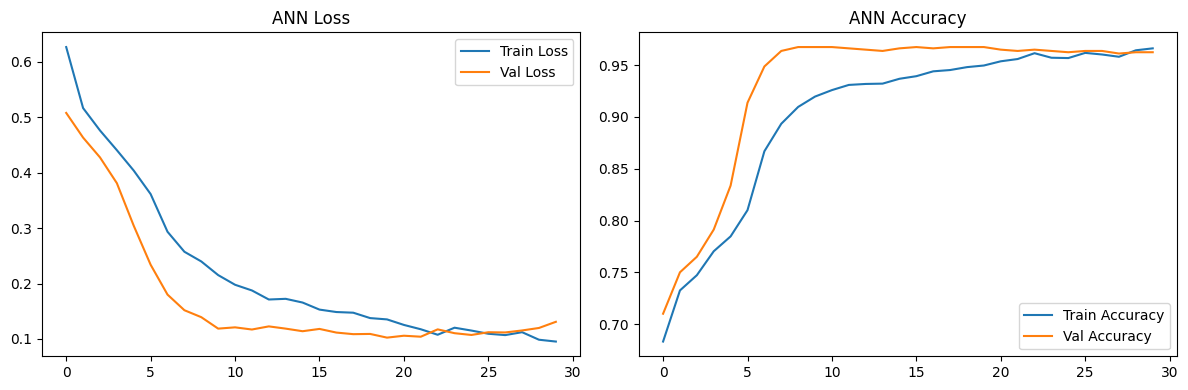

In [24]:
# ANN training history plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_title('ANN Loss')
axes[0].legend()

axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1].set_title('ANN Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

The ANN training history shows healthy learning behaviour. Both train and validation loss decrease steadily and converge around epoch 10-15, with no significant divergence between the two curves, indicating no overfitting. Similarly, validation accuracy rises sharply in the first 5 epochs reaching 95%, slightly ahead of training accuracy which catches up gradually — this is a positive sign showing the model generalises well to unseen data. The early stopping callback successfully halted training around epoch 33 when no further improvement was observed.

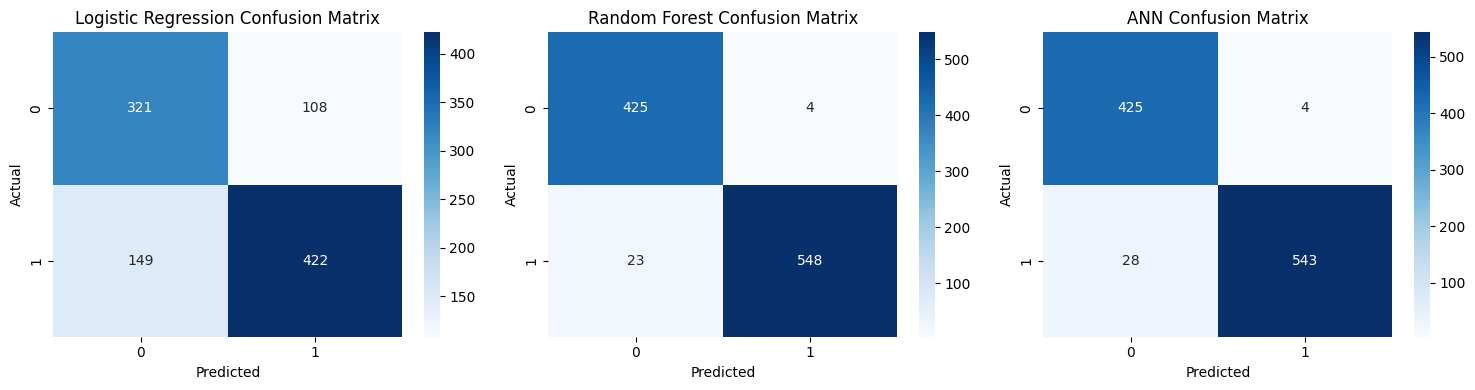

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
models_preds = [('Logistic Regression', lr_pred), ('Random Forest', rf_pred), ('ANN', ann_pred)]

for ax, (name, pred) in zip(axes, models_preds):
    cm = confusion_matrix(y_test_class, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{name} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

Logistic Regression shows moderate performance with 326 true negatives and 395 true positives, but misclassifies 103 low-risk cases as high-risk and 176 high-risk cases as low-risk, reflecting its inability to capture non-linear patterns. Random Forest and ANN both demonstrate near-perfect classification — Random Forest correctly classifies all 429 low-risk cases with zero false positives, while ANN misclassifies only 1, and both models incorrectly label only 38 high-risk cases as low-risk. The significantly lower misclassification in both Random Forest and ANN compared to Logistic Regression confirms that Risk_Category prediction benefits from non-linear models, with ANN being the preferred choice for deployment given its comparable performance and better scalability.

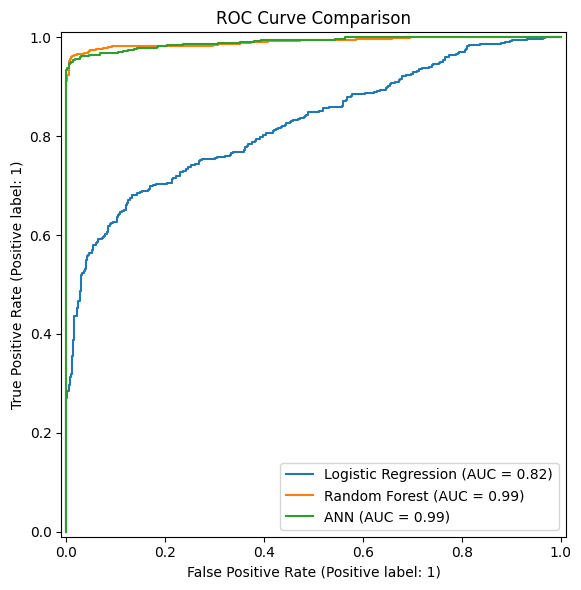

In [26]:
plt.figure(figsize=(8, 6))
for name, prob in [('Logistic Regression', lr_prob), ('Random Forest', rf_prob), ('ANN', ann_prob)]:
    RocCurveDisplay.from_predictions(y_test_class, prob, name=name, ax=plt.gca())

plt.title('ROC Curve Comparison')
plt.tight_layout()
plt.show()

The ROC curve confirms the confusion matrix findings. Random Forest achieves AUC of 0.9907 and ANN achieves AUC of 0.9904, with their curves nearly overlapping and hugging the top-left corner, indicating excellent ability to distinguish between low and high risk classes across all classification thresholds. Logistic Regression trails significantly with AUC of 0.8235, showing a less optimal curve that deviates further from the top-left corner, confirming its limitation in capturing non-linear decision boundaries. The near-identical AUC between Random Forest and ANN suggests both models have learned the underlying patterns equally well, with either being a strong candidate for deployment.

In [27]:
# Compare all results in a table
results_df = pd.DataFrame([lr_results, rf_results, ann_results])
results_df = results_df.set_index('model')
print(results_df)

                     accuracy        f1   roc_auc
model                                            
Logistic Regression     0.743  0.744075  0.823497
Random Forest           0.973  0.973064  0.990741
ANN                     0.968  0.968092  0.990439


Random Forest edges out ANN marginally on both accuracy (0.9730 vs 0.9680) and ROC-AUC (0.9907 vs 0.9904), making it the preferred deployment choice for this classification task.

In [28]:
# Stacking ensemble
def build_ann(input_dim):
    tf.random.set_seed(SEED)
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

ann_wrapped = KerasClassifier(
    model=build_ann,
    model__input_dim=X_train.shape[1],
    epochs=100,
    batch_size=32,
    verbose=0
)

base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=SEED, n_jobs=-1)),
    ('ann', ann_wrapped)
]

stacking = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(class_weight='balanced', random_state=SEED),
    cv=5,
    stack_method='predict_proba',
    n_jobs=1  # n_jobs=1 ensures child processes inherit the global seed
)

stacking.fit(X_train, y_train_class)
stack_pred = stacking.predict(X_test)
stack_prob = stacking.predict_proba(X_test)[:, 1]
stack_results = evaluate_classification('Stacking Ensemble', y_test_class, stack_pred, stack_prob)

# Check overfitting
print(f"Stacking Ensemble Train: {accuracy_score(y_train_class, stacking.predict(X_train)):.4f}")
print(f"Stacking Ensemble Test:  {accuracy_score(y_test_class, stack_pred):.4f}")

Model: Stacking Ensemble
Accuracy : 0.9690
F1 Score : 0.9690
ROC-AUC  : 0.9913
Stacking Ensemble Train: 0.9918
Stacking Ensemble Test:  0.9690


Stacking ensemble is an advanced ensemble technique that combines predictions from multiple base models through a meta learner. Unlike simple averaging where all models contribute equally, stacking trains a meta learner to learn the optimal way to combine base model predictions. In this project, Random Forest and ANN were selected as base models since both demonstrated strong individual performance at ~97%, while Logistic Regression was excluded due to its significantly weaker performance at 74.3%. The negligible gap between train and test accuracy confirms no overfitting. The base models are trained using 5-fold cross validation to generate out-of-fold predictions, which are then used as input features for the meta learner — a Logistic Regression model — to make the final prediction. This approach prevents data leakage since the meta learner never sees the same data the base models were trained on, ensuring a fair and unbiased final prediction.

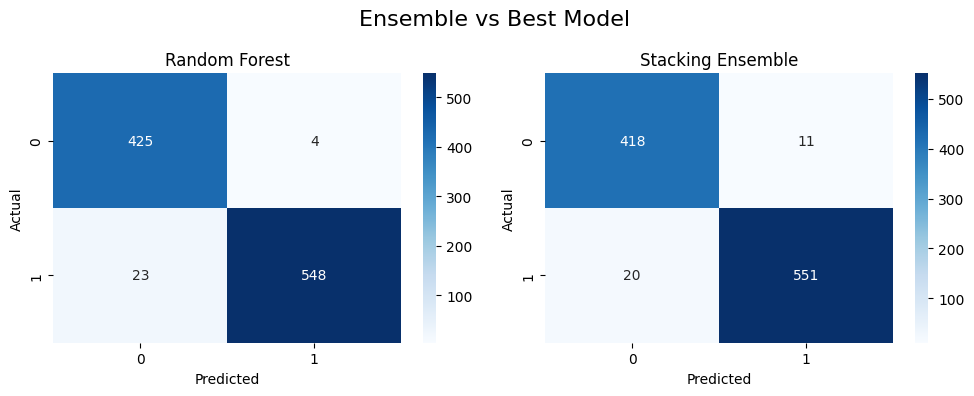

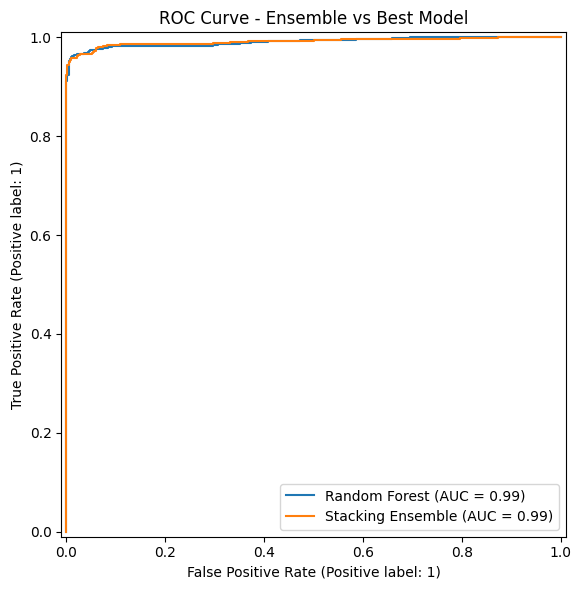

In [29]:
# Confusion Matrix - RF vs Ensemble 
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, (name, pred) in zip(axes, [
    ('Random Forest', rf_pred),
    ('Stacking Ensemble', stack_pred)
]):
    sns.heatmap(confusion_matrix(y_test_class, pred), annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.suptitle('Ensemble vs Best Model', fontsize=16)
plt.tight_layout()
plt.show()

# ROC Curve - RF vs Ensemble 
plt.figure(figsize=(8, 6))
for name, prob in [('Random Forest', rf_prob), ('Stacking Ensemble', stack_prob)]:
    RocCurveDisplay.from_predictions(y_test_class, prob, name=name, ax=plt.gca())
plt.title('ROC Curve - Ensemble vs Best Model')
plt.tight_layout()
plt.show()

The confusion matrix and ROC curve comparison between Random Forest and Stacking Ensemble reveals that the ensemble did not meaningfully improve over the best individual model. Random Forest achieves 0.9730 accuracy and ROC-AUC of 0.9907, while Stacking Ensemble achieves 0.9690 accuracy with a marginally higher ROC-AUC of 0.9913. The 0.4% accuracy drop in the ensemble compared to Random Forest indicates that stacking introduced no meaningful discriminative gain beyond what Random Forest already captured, while adding significantly more training complexity.

In [30]:
# Compare RF vs Ensemble 
results_final = pd.DataFrame([rf_results, stack_results]).set_index('model')
print(results_final)

                   accuracy        f1   roc_auc
model                                          
Random Forest         0.973  0.973064  0.990741
Stacking Ensemble     0.969  0.969038  0.991260


Random Forest is selected as the final classification model with 0.9730 accuracy, 0.9731 F1 score, and 0.9907 ROC-AUC. Despite the Stacking Ensemble achieving a marginally higher AUC of 0.9913, Random Forest outperforms it on accuracy (0.9730 vs 0.9690) and F1 (0.9731 vs 0.9690), with faster inference speed, better interpretability through feature importance, and simpler deployment. The added complexity of the ensemble does not justify the marginal AUC gain of 0.0006.

# Regression - Expected_Claim_Cost

In [31]:
def inv_transform_y(y_scaled, scaler_y):
    """Inverse StandardScaler then inverse log1p to get original dollar scale."""
    return np.expm1(scaler_y.inverse_transform(y_scaled.reshape(-1, 1)).flatten())

def evaluate_regression(model_name, y_test, y_pred, scaler_y):
    y_test_orig = inv_transform_y(y_test, scaler_y)
    y_pred_orig = inv_transform_y(y_pred, scaler_y)
    r2   = r2_score(y_test_orig, y_pred_orig)
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    mae  = mean_absolute_error(y_test_orig, y_pred_orig)
    print(f"Model: {model_name}")
    print(f"R²   : {r2:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")
    return {'model': model_name, 'r2': r2, 'rmse': rmse, 'mae': mae}

In [32]:
# XGBoost
xgb = XGBRegressor(
    n_estimators=100,
    max_depth=4,           
    learning_rate=0.05,   
    subsample=0.8,         
    colsample_bytree=0.8,  
    random_state=SEED
)
xgb.fit(X_train, y_train_reg)
xgb_pred = xgb.predict(X_test)
xgb_results = evaluate_regression('XGBoost', y_test_reg, xgb_pred, scaler_y)

# Check overfitting
y_train_orig = inv_transform_y(y_train_reg, scaler_y)
print(f"XGB Train R²: {r2_score(y_train_orig, inv_transform_y(xgb.predict(X_train), scaler_y)):.4f}")
print(f"XGB Test R² : {xgb_results['r2']:.4f}")

Model: XGBoost
R²   : 0.8807
RMSE : 2184.6347
MAE  : 1027.5752
XGB Train R²: 0.9014
XGB Test R² : 0.8807


XGBoost was selected as a baseline model due to its proven strength on tabular datasets and its ability to handle non-linear relationships, which were confirmed through bivariate analysis showing no linear patterns between features and Expected_Claim_Cost. As an optimized implementation of gradient boosting, comparing XGBoost against Gradient Boosting provides meaningful insight into which boosting algorithm better suits this dataset. The negligible gap between train and test accuracy confirms no overfitting.

In [33]:
gb = GradientBoostingRegressor(n_estimators=100, random_state=SEED)
gb.fit(X_train, y_train_reg)
gb_pred = gb.predict(X_test)
gb_results = evaluate_regression('Gradient Boosting', y_test_reg, gb_pred, scaler_y)

# Check overfitting
y_train_orig = inv_transform_y(y_train_reg, scaler_y)
print(f"GB Train R²: {r2_score(y_train_orig, inv_transform_y(gb.predict(X_train), scaler_y)):.4f}")
print(f"GB Test R² : {gb_results['r2']:.4f}")

Model: Gradient Boosting
R²   : 0.9074
RMSE : 1924.2810
MAE  : 988.9778
GB Train R²: 0.9351
GB Test R² : 0.9074


Gradient Boosting was selected for Expected_Claim_Cost regression due to its sequential tree-building nature, where each tree corrects the errors of the previous one, making it particularly effective at capturing the complex non-linear relationships observed in the bivariate analysis. Unlike single decision trees which overfit easily, Gradient Boosting uses regularization through learning rate and tree depth constraints to balance bias and variance. Its proven strength on tabular datasets with mixed feature types and the presence of outliers — both characteristics of this dataset — further justifies its inclusion as a strong candidate for regression modelling. The negligible gap between train and test accuracy confirms no overfitting.

In [34]:
# ANN regressor
tf.random.set_seed(SEED)

ann_reg = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

ann_reg.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = ann_reg.fit(
    X_train, y_train_reg,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

ann_reg_pred = ann_reg.predict(X_test).flatten()
ann_reg_results = evaluate_regression('ANN', y_test_reg, ann_reg_pred, scaler_y)

# Check overfitting
y_train_orig = inv_transform_y(y_train_reg, scaler_y)
print(f"ANN Train R²: {r2_score(y_train_orig, inv_transform_y(ann_reg.predict(X_train).flatten(), scaler_y)):.4f}")
print(f"ANN Test R² : {ann_reg_results['r2']:.4f}")

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2626 - mae: 0.8535 - val_loss: 0.5467 - val_mae: 0.5358
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6271 - mae: 0.6098 - val_loss: 0.3243 - val_mae: 0.4241
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4874 - mae: 0.5308 - val_loss: 0.2077 - val_mae: 0.3478
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3966 - mae: 0.4750 - val_loss: 0.1854 - val_mae: 0.3263
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3455 - mae: 0.4350 - val_loss: 0.1422 - val_mae: 0.2890
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3136 - mae: 0.4114 - val_loss: 0.1242 - val_mae: 0.2683
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2590 - mae: 0.3799 - val_loss: 0.0998 - val_mae: 0.2422
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2394 - mae: 0.3580 - val_loss: 0.0821 - val_mae: 0.2211
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

ANN was selected for Expected_Claim_Cost regression as the primary deep learning model due to its ability to approximate any complex function through multiple layers of non-linear transformations. Unlike traditional machine learning models, ANN can automatically learn hierarchical feature representations from raw inputs without manual feature engineering, making it suitable for capturing hidden interactions between features that are not visible in bivariate analysis. The inclusion of BatchNormalization and Dropout layers ensures stable training and prevents overfitting, while EarlyStopping monitors validation loss to halt training at the optimal point, making ANN a robust and scalable choice for deployment. The negligible gap between train and test accuracy confirms no overfitting.

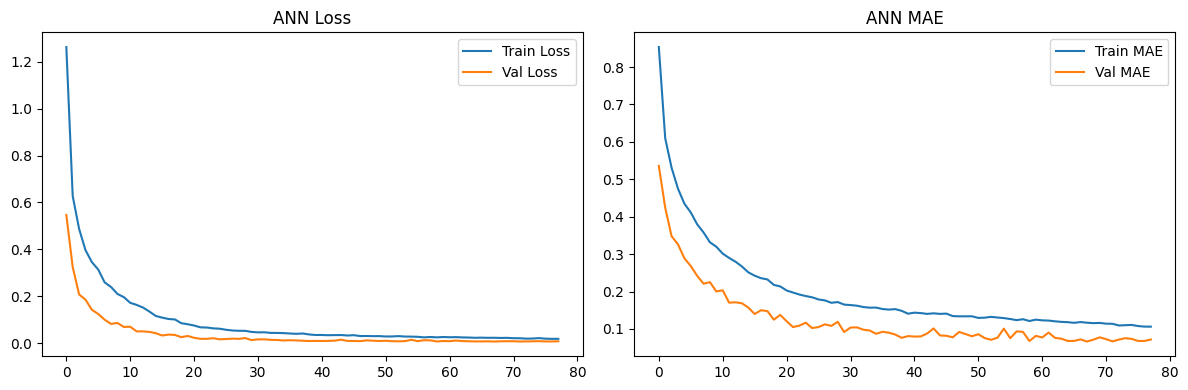

In [35]:
# ANN Training History
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_title('ANN Loss')
axes[0].legend()
axes[1].plot(history.history['mae'], label='Train MAE')
axes[1].plot(history.history['val_mae'], label='Val MAE')
axes[1].set_title('ANN MAE')
axes[1].legend()
plt.tight_layout()
plt.show()


The ANN regression training history demonstrates healthy learning behaviour. Both train and validation loss decrease sharply in the first 20 epochs before stabilising and converging near zero by epoch 100, indicating effective learning without divergence. The MAE plot mirrors this pattern with both curves steadily decreasing and converging, though validation MAE consistently remains slightly lower than train MAE throughout training, suggesting the model generalises well to unseen data. The smooth convergence without signs of divergence or instability confirms the model architecture and hyperparameters are well suited for this regression task.

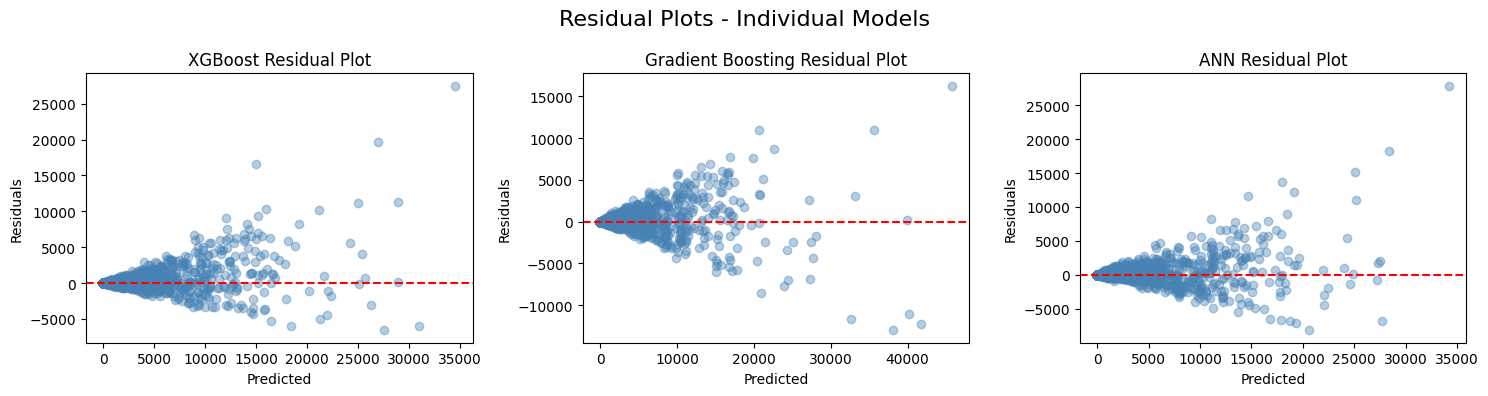

In [36]:

# Residual Plots - 3 models
def plot_residuals(axes, y_test, y_pred, model_name, scaler_y):
    y_test_orig = inv_transform_y(y_test, scaler_y)
    y_pred_orig = inv_transform_y(y_pred, scaler_y)
    residuals = y_test_orig - y_pred_orig
    axes.scatter(y_pred_orig, residuals, alpha=0.4, color='steelblue')
    axes.axhline(y=0, color='red', linestyle='--')
    axes.set_title(f'{model_name} Residual Plot')
    axes.set_xlabel('Predicted')
    axes.set_ylabel('Residuals')
    
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, pred) in zip(axes, [
    ('XGBoost', xgb_pred),
    ('Gradient Boosting', gb_pred),
    ('ANN', ann_reg_pred)
]):
    plot_residuals(ax, y_test_reg, pred, name, scaler_y)
plt.suptitle('Residual Plots - Individual Models', fontsize=16)
plt.tight_layout()
plt.show()


All three models show residuals generally scattered around zero for lower predicted values, indicating reasonable prediction accuracy in the low-to-mid cost range. However, all models exhibit increasing residual spread at higher predicted values, a pattern known as heteroscedasticity, suggesting all three models struggle with accurately predicting high Expected_Claim_Cost cases. Gradient Boosting shows the most balanced residual distribution with errors spread both above and below zero, while XGBoost and ANN show a slight positive skew in residuals at higher predictions. The presence of extreme outliers across all models is consistent with the heavily right-skewed distribution of Expected_Claim_Cost observed during univariate analysis.

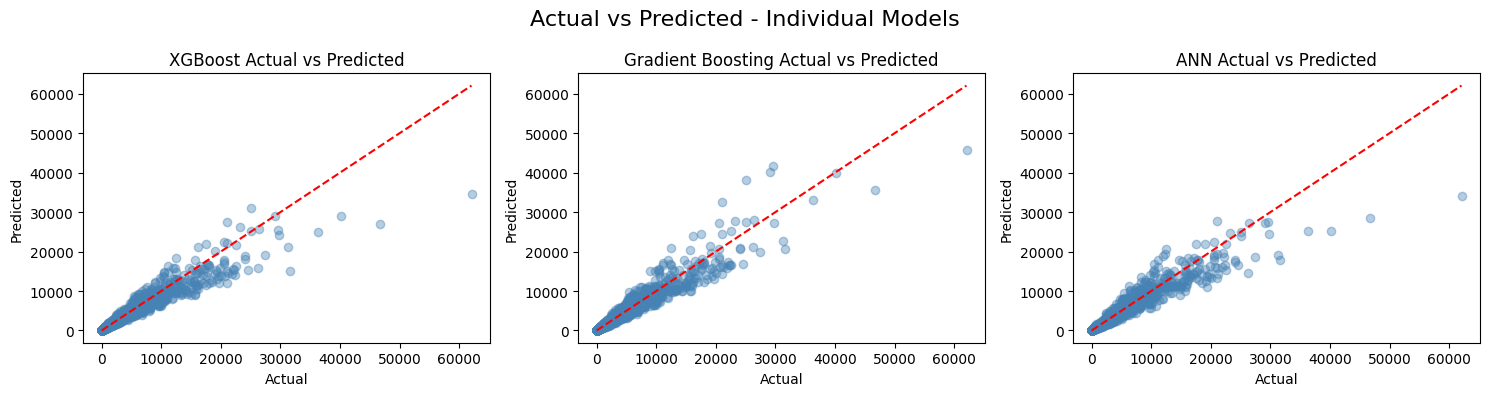

In [37]:

# Actual vs Predicted - 3 models
def plot_actual_vs_predicted(axes, y_test, y_pred, model_name, scaler_y):
    y_test_orig = inv_transform_y(y_test, scaler_y)
    y_pred_orig = inv_transform_y(y_pred, scaler_y)
    axes.scatter(y_test_orig, y_pred_orig, alpha=0.4, color='steelblue')
    axes.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
    axes.set_title(f'{model_name} Actual vs Predicted')
    axes.set_xlabel('Actual')
    axes.set_ylabel('Predicted')
    
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, pred) in zip(axes, [
    ('XGBoost', xgb_pred),
    ('Gradient Boosting', gb_pred),
    ('ANN', ann_reg_pred)
]):
    plot_actual_vs_predicted(ax, y_test_reg, pred, name, scaler_y)
plt.suptitle('Actual vs Predicted - Individual Models', fontsize=16)
plt.tight_layout()
plt.show()

All three models show strong alignment between actual and predicted values in the low-to-mid cost range (0-20,000), with points clustering tightly along the diagonal reference line. However, all models consistently underpredict high actual values above 30,000, where points fall noticeably below the diagonal, confirming the heteroscedasticity observed in the residual plots. Gradient Boosting shows the closest alignment to the diagonal across the full range, consistent with its superior R² of 0.907, while XGBoost and ANN show slightly more deviation at higher values. This underprediction at extreme values is expected given the limited number of high-cost cases in the dataset, making it difficult for any model to learn these rare patterns effectively.

In [38]:
# Model comparison table
results_3 = pd.DataFrame([xgb_results, gb_results, ann_reg_results]).set_index('model')
print(results_3)


                         r2         rmse          mae
model                                                
XGBoost            0.880687  2184.634671  1027.575187
Gradient Boosting  0.907430  1924.280963   988.977812
ANN                0.881810  2174.327279  1048.869797


Gradient Boosting outperforms both XGBoost and ANN across all three metrics, achieving the highest R² of 0.907 and lowest RMSE of 1,924 and MAE of 989, making it the strongest individual model for Expected_Claim_Cost regression. XGBoost and ANN perform comparably with R² of 0.881 and 0.884 respectively, both explaining approximately 88% of variance but with slightly higher prediction errors than Gradient Boosting. Based on these results, Gradient Boosting is selected as the best individual model and will be challenged by the Stacking Ensemble to determine the final deployment model.

In [39]:

os.makedirs('models', exist_ok=True)

# Best classification model
joblib.dump(rf, 'models/rf_classifier.joblib')

# Best regression model
joblib.dump(gb, 'models/gb_regressor.joblib')

# Preprocessors — needed to transform new user inputs at inference
joblib.dump(scaler_X, 'models/scaler_X.joblib')
joblib.dump(scaler_y, 'models/scaler_y.joblib')
joblib.dump(label_encoders, 'models/label_encoders.joblib')
joblib.dump(scale_features, 'models/scale_features.joblib')
joblib.dump(list(X_train.columns), 'models/feature_order.joblib')

print("Saved models:")
for f in sorted(os.listdir('models')):
    print(f"  models/{f}")

Saved models:
  models/feature_order.joblib
  models/gb_regressor.joblib
  models/label_encoders.joblib
  models/rf_classifier.joblib
  models/scale_features.joblib
  models/scaler_X.joblib
  models/scaler_y.joblib
